In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.model_selection import KFold, GridSearchCV
import lightgbm as lgb
import datetime
import xgboost as xgb
import tqdm

analyser = SentimentIntensityAnalyzer()
from category_encoders.cat_boost import CatBoostEncoder
from category_encoders.target_encoder import TargetEncoder

In [2]:
train = pd.read_csv('./dataset/train.csv')
test = pd.read_csv('./dataset/test.csv')

In [3]:
print("The columns are:", *train.columns, sep='\n')

The columns are:
patient_id
name_of_drug
use_case_for_drug
review_by_patient
effectiveness_rating
drug_approved_by_UIC
number_of_times_prescribed
base_score


In [6]:
# rem vals, not used for now
to_keep = list(train['name_of_drug'].value_counts()[:-int(point)].index)
train = train[train['name_of_drug'].isin(to_keep)].reset_index()
point = (train['name_of_drug'].value_counts() <= 3).nonzero()[0][0]

NameError: name 'point' is not defined

In [7]:
def check_score(y_true, y_pred):
    return 100 * max(0, 1 - (mean_squared_error(y_true, y_pred)**0.5))

In [8]:
features = ['name_of_drug',
            'use_case_for_drug',
            'review_by_patient',
            'number_of_times_prescribed']

num_cols = ['number_of_times_prescribed', 'effectiveness_rating']
cat_cols = ['name_of_drug', 'use_case_for_drug']

lstm_cols = ['review_by_patient']

In [11]:
def feature_eng(train, y):    
    ind, maxval = 0, 0
    vals_1 = []
    for k in np.arange(4, 50, 0.3):
        val = abs(pearsonr(train['effectiveness_rating'].apply(lambda x: np.cos(2 * np.pi * x/k)), y)[0])
        if val > maxval:
            maxval = val
            ind = k
        vals_1.append(val)

    print(maxval, ind)
    plt.plot(np.arange(4, 50, 0.3), vals_1)
    plt.scatter(ind, maxval, c='orange')
    plt.grid()
    plt.title('Cosine argument vs. Pearson correlation')
    plt.show()

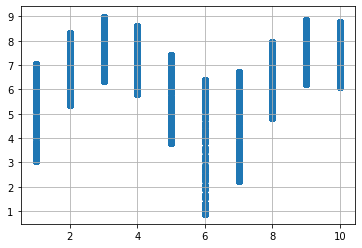

In [6]:
plt.scatter(train['effectiveness_rating'], train['base_score'])
plt.grid()

0.6816218650625303 6.399999999999999


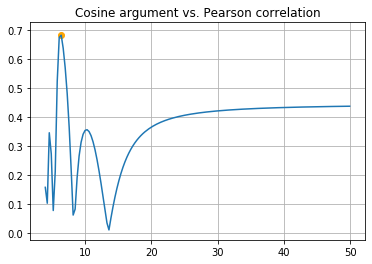

In [12]:
feature_eng(train, train['base_score'])
#pearsonr(train['effectiveness_rating'].apply(lambda x: np.cos(2 * np.pi * x/6.399999999999999 + np.pi)), y)

In [7]:
train['another_col'] = train['effectiveness_rating'].apply(lambda x: np.cos(2 * np.pi * x/6.399999999999999 + np.pi))
cat_cols = ['another_col']
num_cols += cat_cols

In [16]:
def ex_feats(data):
    data['comp'] = data['review_by_patient'].apply(lambda x: analyser.polarity_scores(x)['compound'])
    return data
train = ex_feats(train)
ans = train.groupby('use_case_for_drug').agg({'comp': 'mean'})

KeyboardInterrupt: 

In [24]:
scales = []
for col in cat_cols:  
    cb = TargetEncoder()
    train[col] = cb.fit_transform(train[col].values.reshape(-1, 1), train['effectiveness_rating'].values) 
    scales.append(cb)

In [8]:
num_cols = ['number_of_times_prescribed', 'another_col']
X = train[num_cols].values
y = train['base_score'].values

In [9]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

In [10]:
# custom metrics

def metric_lgb(y_true, y_pred):
    return 'LBMetric', check_score(y_true, y_pred.get_label()), False

def metric_xgb(y_true, y_pred):
    return 'XGMetric', check_score(y_true, y_pred.get_label())

In [11]:
mod2 = GradientBoostingRegressor(verbose=1, max_depth=31, n_estimators=100)
mod2.fit(X_train, y_train)
print(check_score(y_val, mod2.predict(X_val)))
print(check_score(y_train, mod2.predict(X_train)))

      Iter       Train Loss   Remaining Time 
         1           2.0564            9.66s
         2           1.6756           10.43s
         3           1.3672           10.31s
         4           1.1171           10.33s
         5           0.9147           10.33s
         6           0.7506           10.22s
         7           0.6174           10.11s
         8           0.5092           10.00s
         9           0.4210            9.86s
        10           0.3493            9.76s
        20           0.0675            8.80s
        30           0.0161            7.70s
        40           0.0036            6.65s
        50           0.0009            5.61s
        60           0.0003            4.41s
        70           0.0001            3.25s
        80           0.0000            2.13s
        90           0.0000            1.04s
       100           0.0000            0.00s
85.55854297746843
99.82752451163982


In [12]:
train_set = lgb.Dataset(X_train, y_train)
val_set = lgb.Dataset(X_val, y_val)

params ={
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'seed': 42,
    'metric': 'rmse',
    #'num_leaves': 127,
    'learning_rate': 0.08
}

model = lgb.train(train_set=train_set, 
                  valid_sets=val_set, 
                  params=params, 
                  verbose_eval=100, 
                  num_boost_round=800, 
                  feval=metric_lgb,
                  feature_name=num_cols)

print(check_score(y_val, model.predict(X_val)))
print(check_score(y_train, model.predict(X_train)))

[100]	valid_0's rmse: 0.234139	valid_0's LBMetric: 76.5861
[200]	valid_0's rmse: 0.149146	valid_0's LBMetric: 85.0854
[300]	valid_0's rmse: 0.128029	valid_0's LBMetric: 87.1971
[400]	valid_0's rmse: 0.119557	valid_0's LBMetric: 88.0443
[500]	valid_0's rmse: 0.114879	valid_0's LBMetric: 88.5121
[600]	valid_0's rmse: 0.110233	valid_0's LBMetric: 88.9767
[700]	valid_0's rmse: 0.107273	valid_0's LBMetric: 89.2727
[800]	valid_0's rmse: 0.105343	valid_0's LBMetric: 89.4657
89.46565826478631
93.55459661060974


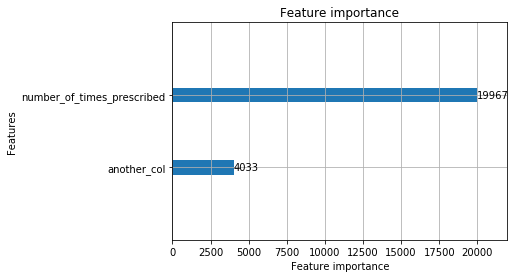

In [67]:
lgb.plot_importance(model)

In [71]:
train_set_xg = xgb.DMatrix(X_train, label=y_train, feature_names=num_cols)
val_set_xg = xgb.DMatrix(X_val, label=y_val, feature_names=num_cols)

params_xg ={
    'objective': 'reg:squarederror',
    #'booster': '',
    'verbosity': 1,
}

model_xg = xgb.train(params_xg, train_set_xg, 
                  num_boost_round=85, 
                  evals=[[val_set_xg, 'eval']],
                  feval=metric_xgb,
                  #maximize=True,
                  verbose_eval = 100)

print(check_score(y_val, model_xg.predict(xgb.DMatrix(X_val, feature_names=num_cols))))
print(check_score(y_train, model_xg.predict(xgb.DMatrix(X_train, feature_names=num_cols))))

[0]	eval-rmse:4.49584	eval-XGMetric:0.00000
[84]	eval-rmse:0.10429	eval-XGMetric:89.57119
89.5711937526557
93.3616318243516


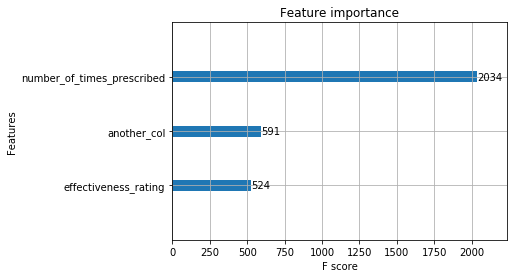

In [63]:
xgb.plot_importance(model_xg)

In [134]:
parameters = {'objective':['reg:squarederror'],
              'learning_rate': [0.05], #so called `eta` value
              'max_depth': [6, 12, 20, 31],
              'min_child_weight': [11],
              'silent': [1],
              'subsample': [0.8, 1.0],
              'colsample_bytree': [0.7, 1.0],
              'n_estimators': [100, 500, 1000], #number of trees, change it to 1000 for better results
              'seed': [1337]}

xgb_model = xgb.XGBRegressor()

clf = GridSearchCV(xgb_model, parameters, n_jobs=5, 
                   cv=KFold(n_splits=5, shuffle=True), 
                   verbose=2, refit=True)

clf.fit(X, y)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:  1.3min
[Parallel(n_jobs=5)]: Done 152 tasks      | elapsed: 10.2min
[Parallel(n_jobs=5)]: Done 240 out of 240 | elapsed: 21.2min finished


GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=True),
             error_score='raise-deprecating',
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_c...
                                    validate_parameters=False, verbosity=None),
             iid='warn', n_jobs=5,
             param_grid={'colsample_bytree': [0.7, 1.0],
                         'learning_rate': [0.05], 'max_depth': [6, 12, 20, 31],
                         'min_child_weight': [11],
                         'n_estimators': [100, 50

In [156]:
import pickle
pkl_filename = "pickle_model.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(clf, file)

In [137]:
for i, col in enumerate(cat_cols):
    test[col] = scales[i].transform(test[col].values.reshape(-1, 1))
test['another_col'] = (test['effectiveness_rating'].apply(lambda x: np.cos(2 * np.pi * x/6.399999999999999 + np.pi)))
data_t = test[num_cols].values

In [135]:
print(check_score(y_val, clf.predict(X_val)))
print(check_score(y_train, clf.predict(X_train)))

96.63933852635613
96.86621381727247


In [61]:
# simple ratio ensemble

vals=[]
p1 = model.predict(X_val)
p2 = model_xg.predict(xgb.DMatrix(X_val, feature_names=num_cols))

for x_ in tqdm.tqdm_notebook(np.arange(0, 1.01, 0.01)):
    pred = x_ * p1 + (1-x_) * p2
    vals.append([check_score(y_val, pred), x_])

print(max(vals))

c:\users\siddh\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys



[94.99731943251747, 0.87]


In [13]:
x_ = 0.43
p1 = model.predict(data_t)
p2 = model_xg.predict(xgb.DMatrix(data_t, feature_names=num_cols))
preds = x_ * p1 + (1-x_) * p2

In [150]:
preds = model_xg.predict(xgb.DMatrix(data_t, feature_names=num_cols))#clf.predict(data_t)

In [151]:
sub = pd.DataFrame()
sub['patient_id'] = test['patient_id']
sub['base_score'] = preds
sub.to_csv('submission_1.csv', index=False)